<a href="https://colab.research.google.com/github/s-mishra/statrethinking_lectures_numpyro/blob/main/week1/iwona_rethinking_week1_chapters1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Useful links:

* [HOMEWORK](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework)

* [Book code translated into NumPyro](https://fehiepsi.github.io/rethinking-numpyro/)

* [Book and homework code in Python/PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking_2)

* [NumPyro documentation](http://num.pyro.ai/en/stable/api.html)

* [NumPyro examples](http://num.pyro.ai/en/latest/index.html#introductory-tutorials)

* [Other languagaes and videos](https://github.com/rmcelreath/stat_rethinking_2020)

In [ ]:
!pip install numpyro

In [ ]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap
import jax 

import numpyro
import numpyro.distributions as dist

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

# Homework week 1

 https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework/week01

## Exercise 1

Suppose the globe tossing data (Chapter 2) had turned out to be 4 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as in the book.

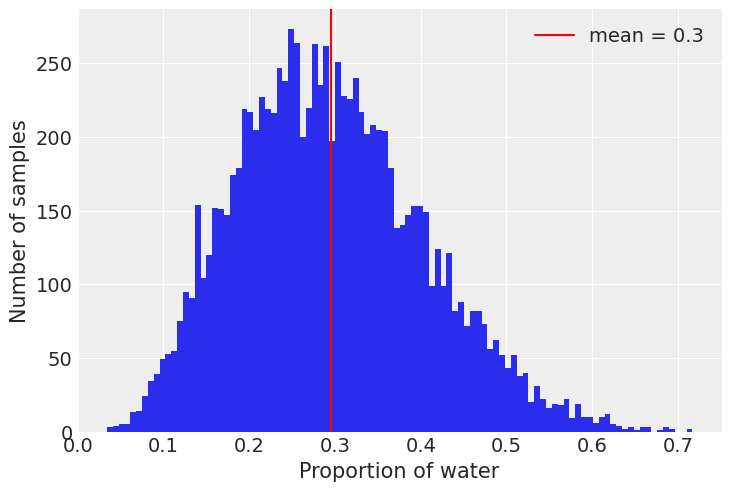

In [ ]:
W = 4 # number of 'Water' outcome
N = 15 # total tosses

# here we could just use numpy (np) but we're trying to use jax.numpy so jnp -- but usage seems to be the same
p_grid = jnp.linspace(start=0, stop=1, num=1000)  # define a grid: 1000 points between 0 and 1
prior = jnp.repeat(1, 1000)  # uniform (flat) prior: repeat '1' a 1000 times

#import numpyro.distributions as dist
likelihood = jnp.exp(dist.Binomial(total_count=N, probs=p_grid).log_prob(W))
posterior = likelihood * prior
posterior = posterior / posterior.sum()  # normalise
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]  # sample 10000 from the p_grid using the probabilites from the posterior

plt.figure()
# plt.plot(p_grid, posterior, label = 'posterior')
# plt.plot(p_grid, prior / prior.sum(), label = 'prior')
plt.hist(samples, bins=100)
plt.axvline(x=samples.mean(), label='mean = ' + str(round(samples.mean(),2)), c='red')

plt.xlabel('Proportion of water')
plt.ylabel('Number of samples')
plt.legend()
plt.show()

## Exercise 2

Start over in 1, but now use a prior that is zero below p=0.5 and a constant above p=0.5. This corresponds to prior information that a majority of the Earth’s surface is water. What difference does the better prior make?

Maximum posterior probability for uniform prior is 0.26626626
Maximum posterior probability for stepwise prior is 0.5005005
Mean posterior for uniform prior is 0.29537228
Mean posterior for stepwise prior is 0.5499942


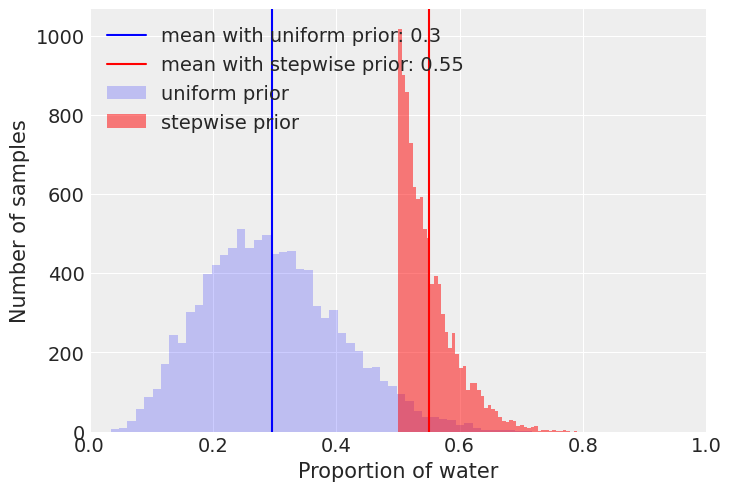

In [ ]:
prior2a = jnp.zeros(500)
prior2b = jnp.ones(500)
prior2 = jnp.concatenate([prior2a, prior2b])
# # prior2[p_grid >= 0.5] = 1  # this should work but it doesn't????
# n_less_than_05 = len(p_grid[p_grid < 0.5])
# prior2 = jax.ops.index_update(prior2, jax.ops.index[0:n_less_than_05], 0.)
# # this was weirdly complicated, would be so easy in numpy... But somehow in jax numpy you can just change values of an array???


# likelihood2 = jnp.exp(dist.Binomial(total_count=N, probs=p_grid).log_prob(W))
posterior2 = likelihood * prior2  # likelihood is the same but now we're using the new prior
posterior2 = posterior2 / posterior2.sum()  # normalise
samples2 = p_grid[dist.Categorical(probs=posterior2).sample(random.PRNGKey(0), (10000,))]  # sampling form the enw posterior

print('Maximum posterior probability for uniform prior is', p_grid[jnp.argmax(posterior)])
print('Maximum posterior probability for stepwise prior is', p_grid[jnp.argmax(posterior2)])

print('Mean posterior for uniform prior is', samples.mean())
print('Mean posterior for stepwise prior is', samples2.mean())


plt.figure()
# plt.plot(p_grid, posterior, c= 'blue', label='posterior with uniform prior')
# plt.plot(p_grid, prior/prior.sum(),c = 'blue', ls = '--', label='uniform prior')
# plt.plot(p_grid, posterior2, c = 'red', label='posterior with stepwise prior')
# plt.plot(p_grid, prior2/prior2.sum(),c = 'red', ls = '--', label='stepwise prior')
# plt.ylabel('Density')

plt.hist(samples, bins=50, color='blue', alpha=0.2, label = 'uniform prior')
plt.axvline(x=samples.mean(), label='mean with uniform prior: ' + str(round(samples.mean(),2)), c='blue')

plt.hist(samples2, bins=50, color='red', alpha=0.5, label = 'stepwise prior')
plt.axvline(x=samples2.mean(), label='mean with stepwise prior: ' + str(round(samples2.mean(),2)), c='red')

plt.legend(loc='upper left')
plt.xlabel('Proportion of water')
plt.ylabel('Number of samples')

plt.xlim(0,1)
plt.show()


## Exercise 3

For the posterior distribution from 2, compute 89% percentile and HPDI intervals. Compare the widths of these intervals. Which is wider? Why? If you had only the information in the interval, what might you misunderstand about the shape of the posterior distribution?

HPDI = Highest Posterior Density Interval

89% percentile interval: [0.5035035 0.6356356]
89% hpdi: [0.5005005 0.6076076]
89% percentile interval has a width of 0.132
89% hpdi has a width of 0.107
89% percentile is wider


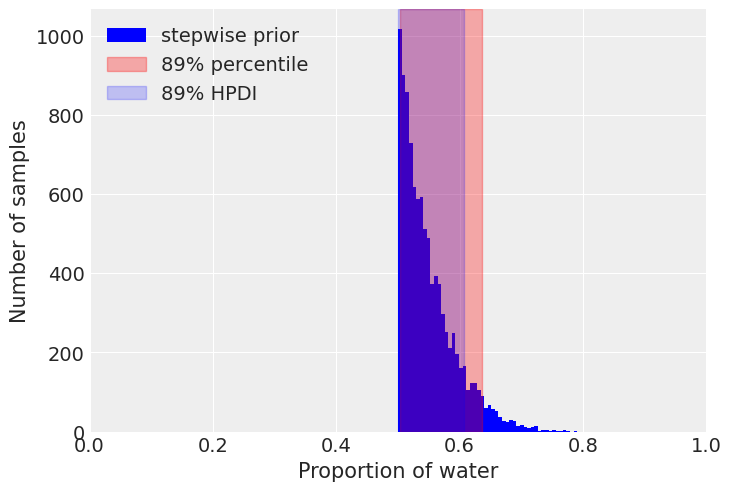

In [ ]:
samples = p_grid[dist.Categorical(probs=posterior2).sample(random.PRNGKey(0), (10000,))]  # sample form the posterior2 first

# I'm assuming the question is about the middle 89%

q = [5.5, 94.5]  # this is the interval we're interested in for the percentile
percentile89 = jnp.percentile(samples, q=q)  # this is a tuple (i.e. two values)
hpdi89 = numpyro.diagnostics.hpdi(samples, prob=0.89) # this is a tuple (i.e. two values)

print('89% percentile interval:', percentile89)
print('89% hpdi:', hpdi89)


print('89% percentile interval has a width of', round(percentile89[1] - percentile89[0],3))
print('89% hpdi has a width of', round(hpdi89[1] - hpdi89[0],3))


print('89% percentile is wider')

plt.figure()
# plt.plot(p_grid, posterior, label='Uniform prior')
# plt.plot(p_grid, posterior2, color = 'red', label='posterior with stepwise prior')
plt.hist(samples2, bins=50, color='blue', alpha=1.0, label = 'stepwise prior')

plt.axvspan(percentile89[0], percentile89[1], alpha=0.3, color='red', label = '89% percentile')
plt.axvspan(hpdi89[0], hpdi89[1], alpha=0.2, color='blue', label = '89% HPDI')

plt.legend(loc='upper left')
plt.xlabel('Proportion of water')
plt.ylabel('Number of samples')
plt.xlim(0,1)

plt.show()



# End of the chapter exercises

# 3H1

Using grid approximation, compute the posterior distribution for the probability of a birth being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/homeworkch3.csv')
df.head()

,birth1,birth2
0,1,0
1,0,1
2,0,0
3,0,1
4,1,0


boys: 111 girls: 89 total: 200
Maximum posterior probability =  0.5545546


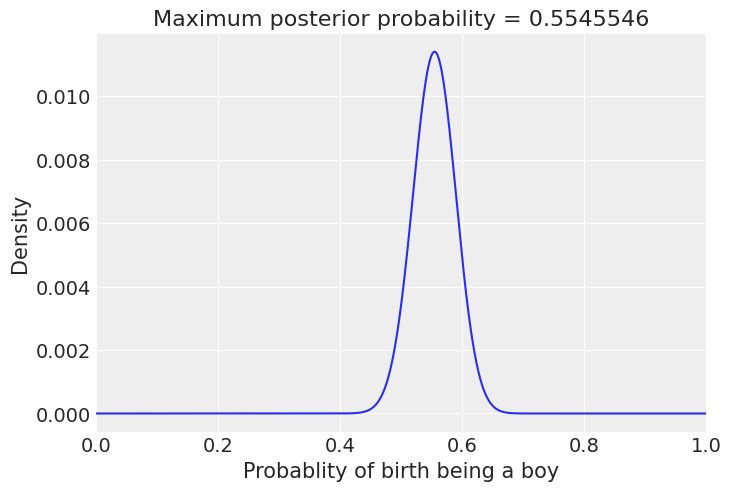

Maximum posterior probability =  0.5545546


In [ ]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)  # define a grid
prior = jnp.repeat(1, 1000)  # uniform prior

num_boys = jnp.sum(df.birth1.values) + jnp.sum(df.birth2.values)  # boys are 1-s
num_girls = len(df.index)*2 - num_boys
print('boys:', num_boys, 'girls:', num_girls, 'total:', num_boys+num_girls)

likelihood = jnp.exp(dist.Binomial(total_count=num_boys+num_girls, probs=p_grid).log_prob(num_boys))

posterior = likelihood * prior

posterior = posterior / jnp.sum(posterior) # normalise the posterior
maximum_posterior_prob = p_grid[jnp.argmax(posterior)]
print('Maximum posterior probability = ', maximum_posterior_prob)

plt.figure()
plt.plot(p_grid, posterior)
plt.xlabel('Probablity of birth being a boy')
plt.ylabel('Density')
plt.title('Maximum posterior probability = ' + str(maximum_posterior_prob))
plt.xlim([0,1])

plt.show()

maximum_posterior_prob = p_grid[jnp.argmax(posterior)]
print('Maximum posterior probability = ', maximum_posterior_prob)


# 3H2

Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior density intervals.

50% HPDI: [0.5275275 0.5745746]
89% HPDI: [0.4974975 0.6096096]
97% HPDI: [0.4804805 0.6326326]


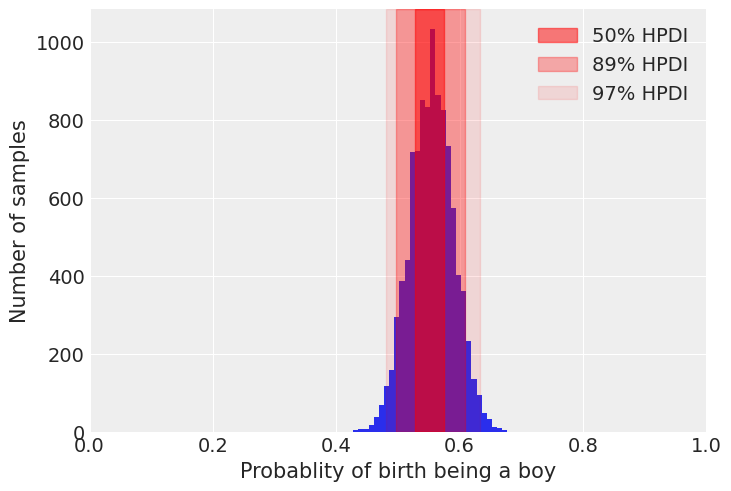

In [ ]:
# Draw 10k random parameters values from the posterior and estimate the HPDI
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

hpdi50 = numpyro.diagnostics.hpdi(samples, prob=0.5)
hpdi89 = numpyro.diagnostics.hpdi(samples, prob=0.89)
hpdi97 = numpyro.diagnostics.hpdi(samples, prob=0.97)

print('50% HPDI:', hpdi50)
print('89% HPDI:', hpdi89)
print('97% HPDI:', hpdi97)

plt.figure()
plt.hist(samples, bins = 30)
plt.xlabel('Probablity of birth being a boy')
plt.ylabel('Number of samples')

plt.axvspan(hpdi50[0], hpdi50[1], alpha=0.5, color='red', label = '50% HPDI')
plt.axvspan(hpdi89[0], hpdi89[1], alpha=0.3, color='red', label = '89% HPDI')
plt.axvspan(hpdi97[0], hpdi97[1], alpha=0.1, color='red', label = '97% HPDI')

plt.xlim([0,1])
plt.legend()
plt.show()


# 3H3

Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to visualize the simulations, but the dens command (part of the rethinking package) is probably the easiest way in this case. Does it look like the model fits the data well? That is, does the distribution of predictions include the actual observation as a central, likely outcome?

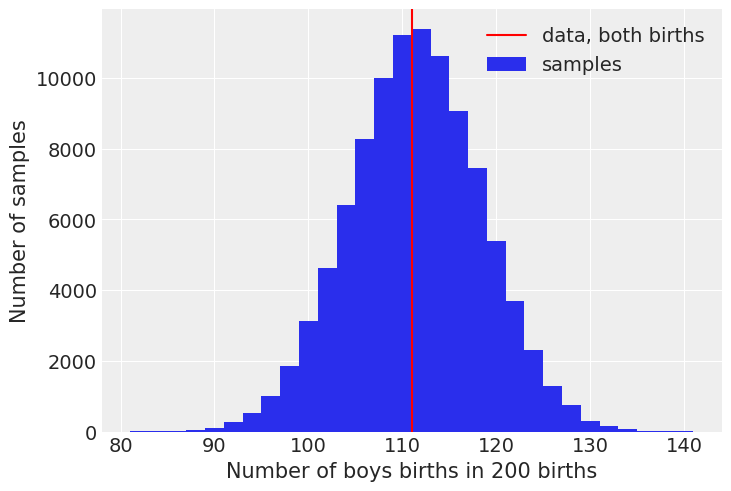

In [ ]:
many_samples = dist.Binomial(total_count=200, probs=maximum_posterior_prob).sample(random.PRNGKey(0), (100000,))
plt.hist(many_samples, bins=30, label = 'samples')
plt.axvline(x=num_boys, label='data, both births', c='red')
plt.legend()
plt.xlabel('Number of boys births in 200 births')
plt.ylabel('Number of samples')
plt.show()

# 3H4

Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys in the first births, birth1. How does the model look in this light?

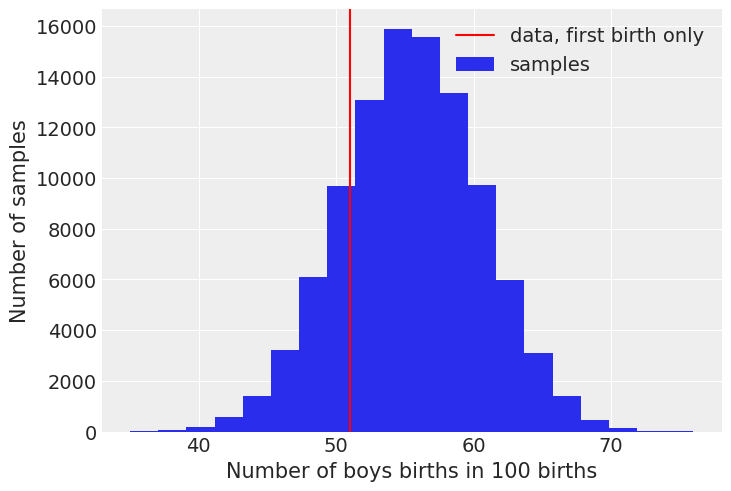

In [ ]:
many_samples = dist.Binomial(total_count=100, probs=maximum_posterior_prob).sample(random.PRNGKey(0), (100000,))
plt.hist(many_samples, bins=20, label = 'samples')
plt.axvline(x=df.birth1.values.sum(), label='data, first birth only', c='red')
plt.legend()
plt.xlabel('Number of boys births in 100 births')
plt.ylabel('Number of samples')
plt.show()

# 3H5

The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts of boys to only those second births that followed girls. To do this correctly, you need to count the number of first borns who were girls and simulate that many births, 10,000 times. Compare the counts of boys in your simulations to the actual observed count of boys following girls. How does the model look in this light? Any guesses what is going on in these data?

In [ ]:
# how many boys after first girl
num_boys_after_girl = len(df[(df.birth1 == 0) & (df.birth2 == 1)].index)
first_girl = len(df[(df.birth1 == 0)].index)

print('There were', num_boys_after_girl, 'boys born after a girl was born in 100 pairs of births')
print('There were', first_girl, 'girls firstborn')

There were 39 boys born after a girl was born in 100 pairs of births
There were 49 girls firstborn


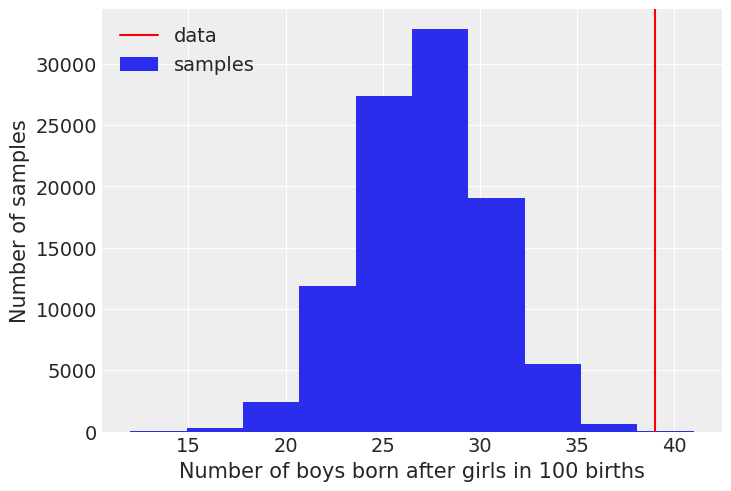

In [ ]:
many_samples1 = dist.Binomial(total_count=first_girl, probs=maximum_posterior_prob).sample(random.PRNGKey(0), (100000,))
plt.figure()
plt.hist(many_samples1, label = 'samples')
plt.axvline(x=num_boys_after_girl, label='data', c='red')
plt.legend()
plt.xlabel('Number of boys born after girls in 100 births')
plt.ylabel('Number of samples')
plt.show()

Not fully sure why this tests the assumption of independent first and second bith sexes????